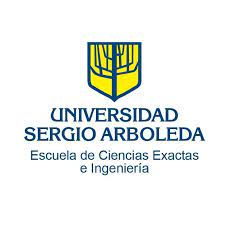

# **Programa de Ciencias de la Computación e Inteligencia Artificial**
---

### **Parcial Final**
> **Profesor**: John Jairo Corredor Franco

> **Autor**: Carlos Alberto Arévalo Martínez

> **Fecha**: 23 de Mayo de 2022

> **Materia**: High Performance Computing 03 (HPC-03)

# 1. Se importan las bibliotecas necesarias (libraries)

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from IPython.core.pylabtools import figsize
from sklearn.metrics import r2_score

# 2. Se importan los resultados obtenidos en el modelo implementado en C++ (modelo de regresión lineal)

In [40]:
costoCpp_train = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/ModeloC++/Debug/vectorCosto_train.txt", header=None)
thetaCpp_train = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/ModeloC++/Debug/vectorTheta_train.txt", header=None)
y_hatCpp_train = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/ModeloC++/Debug/prediccion_train.txt", header=None)
costoCpp_test = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/ModeloC++/Debug/vectorCosto_test.txt", header=None)
thetaCpp_test = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/ModeloC++/Debug/vectorTheta_test.txt", header=None)
y_hatCpp_test = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/ModeloC++/Debug/prediccion_test.txt", header=None)

# 3. Se importa el dataset California House

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/ModeloC++/DATASETS/californiaHousingHPC_withheader.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1925.0000,65500.0


# 4. Se realiza el EDA (Análisis exploratorio de los datos)

In [7]:
# 4.1.- Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            16999 non-null  float64
 2   housing_median_age  16998 non-null  float64
 3   total_rooms         16998 non-null  float64
 4   total_bedrooms      16999 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [8]:
# 4.2.- Se observa un resumen estadístico de los datos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,17000.0,-119.562108,2.005166,-124.3500,-121.7900,-118.49,-118.000,-114.31
latitude,16999.0,35.625311,2.137373,32.5400,33.9300,34.25,37.720,41.95
housing_median_age,16998.0,28.591717,12.585593,1.0000,18.0000,29.00,37.000,52.00
total_rooms,16998.0,2643.287857,2179.244192,2.0000,1462.0000,2127.00,3150.750,37937.00
total_bedrooms,16999.0,539.425260,421.507647,1.0000,297.0000,434.00,648.500,6445.00
population,17000.0,1429.573941,1147.852959,3.0000,790.0000,1167.00,1721.000,35682.00
households,17000.0,501.221941,384.520841,1.0000,282.0000,409.00,605.250,6082.00
median_income,17000.0,385.417016,1276.462977,0.4999,2.6618,3.75,5.423,13947.00
median_house_value,17000.0,207300.912353,115983.764387,14999.0000,119400.0000,180400.00,265000.000,500001.00


Se decide imputar los datos faltantes con los vecinos más cercanos (KNN), de las columnas: **latitude**, **housing_median_age**, **total_rooms**, **total_bedrooms**


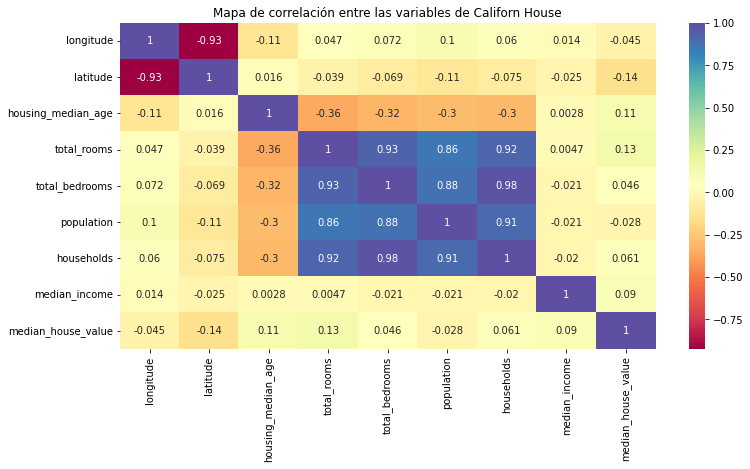

In [9]:
# 4.3.- A continuación, se presenta la matriz de correlación: Representa
# el grado de afinidad entre las variables. Si el Factor es cercano a
# 1 o -1, representa una alta afinidad o relación (directa o indirectamente
# proporcional)
mathCorr = df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(mathCorr, annot=True, cmap='Spectral')
plt.title('Mapa de correlación entre las variables de Californ House')
plt.show()

Dada esa matriz de correlación, se presume que no hay una relación inversamente proporcional entre la variable dependiente e independientes, por lo tanto, se evidencia que presenta una relación significativamente baja.

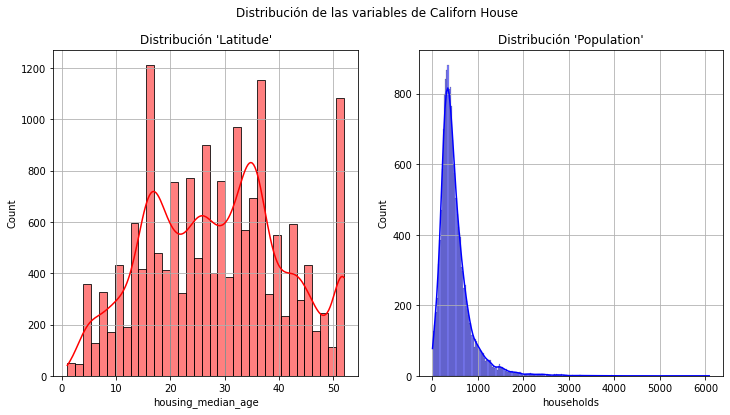

In [10]:
# 4.4.- A continuación, se presenta la distribución de las variables
# (se espera que la distribución de todas las varibales sea Normal-Gaussiana)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Distribución de las variables de Californ House')
sns.histplot(df['housing_median_age'], kde=True, color='r', ax=axes[0])
sns.histplot(df['households'], kde=True, color='b', ax=axes[1])
axes[0].grid()
axes[0].set_title("Distribución 'Latitude'")
axes[1].grid()
axes[1].set_title("Distribución 'Population'")
plt.show()

Se puede apreciar que las variables no presentan una distribución 'normal'. Por ende se procede a aplicar **PowerTransformer** que hace que los datos sean más gaussianos.


# 5. Se separa en 2 grupos: variables dependientes e independientes

In [41]:
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']

# 6. Se dividen los datos en 2 grupos: prueba y entrenamiento (test, train)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)

# 7. Pipeline donde se implementan métodos de imputación, escalado, transformación de potencia y modelo de Regresión Lineal.

In [42]:
pipe = Pipeline([('Imputer', KNNImputer(n_neighbors=5)),
                 ('Scaler', StandardScaler()),
                 ('Gaussian', PowerTransformer(method='yeo-johnson', standardize=True)), 
                 ('ModelLR', LinearRegression())])

In [43]:
# Se entrena el pipe
pipe.fit(X_train, y_train)

Pipeline(steps=[('Imputer', KNNImputer()), ('Scaler', StandardScaler()),
                ('Gaussian', PowerTransformer()),
                ('ModelLR', LinearRegression())])

# 8. Vector de coeficientes y punto de corte del modelo LR

In [44]:
print(f"Vector de coeficientes: {pipe.steps[3][1].coef_}")
print(f"Punto intercepto: {pipe.steps[3][1].intercept_}")

Vector de coeficientes: [ -85311.45107139 -107125.62095851    8454.41334786  120174.2323868
  -71836.48331268  -70857.69884878   30959.09441453    2006.04430643]
Punto intercepto: 197507.07625


# 9. Crear vectores de predicciones del modelo LR Sklearn (y_train_hat_sk, y_test_hat_sk)

In [21]:
# Se toman los valores de predicción de entrenamiento
y_train_hat_sk = pipe.predict(X_train)

In [24]:
# Se toman los valores de predicción de prueba
y_test_hat_sk = pipe.predict(X_test)

# 10. Evaluar el modelo LR Sklearn para entrenamiento y prueba

In [58]:
# Entrenamiento
r2Sk_train = r2_score(y_train, y_train_hat_sk)
r2Cpp_train = r2_score(y_train, y_hatCpp_train)
print(f'Métrica de rendimiento SK train (r2_score) {r2Sk_train*100:.2f}%')
print(f'Métrica de rendimiento CPP train (r2_score) {r2Cpp_train*100:.2f}%')

Métrica de rendimiento SK train (r2_score) 39.38%
Métrica de rendimiento CPP train (r2_score) 28.43%


In [59]:
# Prueba
r2Sk_test = r2_score(y_test, y_test_hat_sk)
r2Cpp_test = r2_score(y_test, y_hatCpp_test)
print(f'Métrica de rendimiento SK test (r2_score) {r2Sk_test*100:.2f}%')
print(f'Métrica de rendimiento CPP test (r2_score) {r2Cpp_test*100:.2f}%')

Métrica de rendimiento SK test (r2_score) 24.24%
Métrica de rendimiento CPP test (r2_score) 33.70%


El rendimiento del modelo de entrenamiento realizado en Python es más efectivo que el de C++. Un posible factor se debe a que al de python se le implementó más métodos para mejorar la efectividad del modelo.

# 11. Gráfico de la función de costo del modelo Cpp

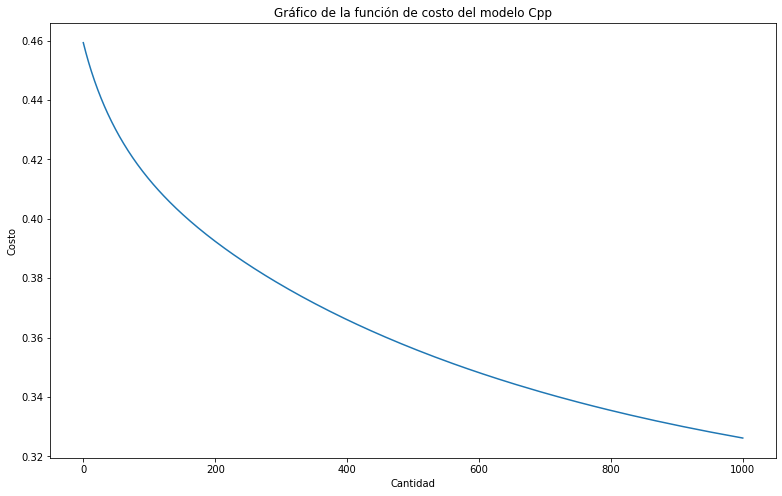

In [72]:
fig, axes = plt.subplots(figsize=(13, 8))
plt.plot(costoCpp_train)
plt.title('Gráfico de la función de costo del modelo Cpp')
plt.ylabel('Costo')
plt.xlabel('Cantidad')
plt.show()

# 12. Gráfico comparativo de "Predicciones de entrenamiento modelo Sklearn vs predicciones de entrenamiento del modelo Cpp"

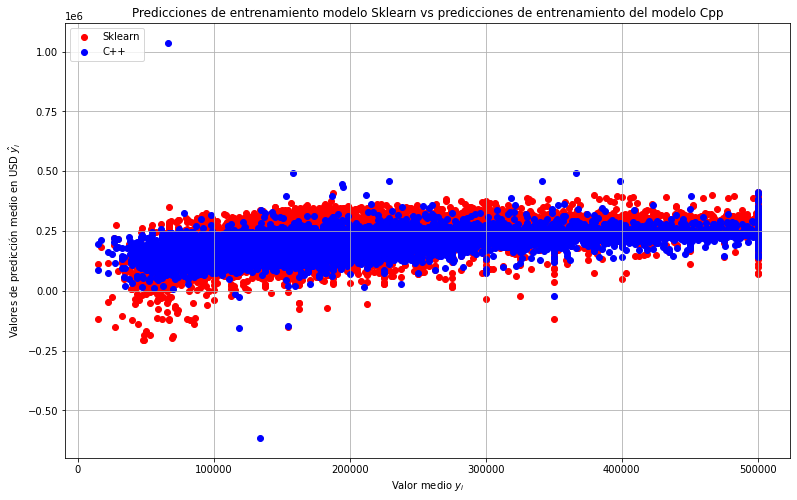

In [69]:
# Se presentan las gráficas de predicciones de entrenamiento entre el 
# modelo C++ y el modelo Sklearn
fig, axes = plt.subplots(figsize=(13, 8))
plt.scatter(y_train, y_train_hat_sk, c='r', label='Sklearn')
plt.scatter(y_train, y_hatCpp_train, c='b', label='C++')
plt.legend(loc=2)
plt.grid()
plt.title('Predicciones de entrenamiento modelo Sklearn vs predicciones de entrenamiento del modelo Cpp')
plt.xlabel('Valor medio $y_i$')
plt.ylabel('Valores de predicción medio en USD $\hat{y_i}$')
plt.show()

# 13. Gráfico comparativo de "Predicciones de prueba modelo Sklearn vs predicciones de prueba del modelo Cpp"

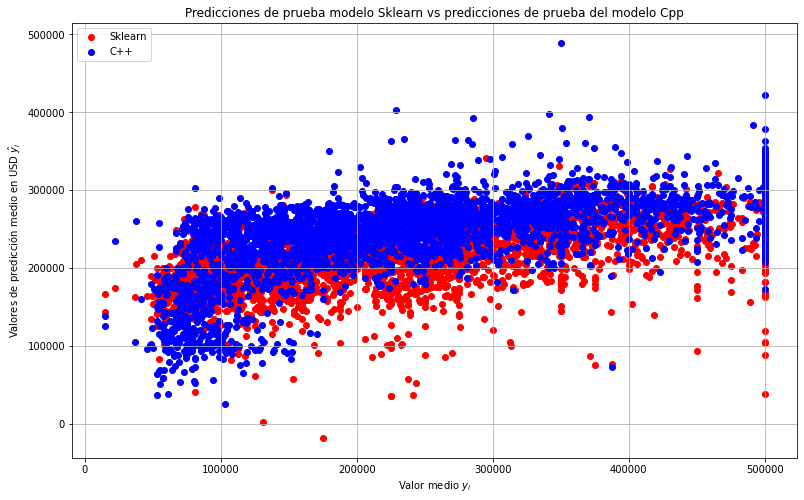

In [70]:
# Se presentan las gráficas de predicciones de prueba entre el 
# modelo C++ y el modelo Sklearn
fig, axes = plt.subplots(figsize=(13, 8))
plt.scatter(y_test, y_test_hat_sk, c='r', label='Sklearn')
plt.scatter(y_test, y_hatCpp_test, c='b', label='C++')
plt.legend(loc=2)
plt.grid()
plt.title('Predicciones de prueba modelo Sklearn vs predicciones de prueba del modelo Cpp')
plt.xlabel('Valor medio $y_i$')
plt.ylabel('Valores de predicción medio en USD $\hat{y_i}$')
plt.show()